In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import butter, lfilter
from scipy.fftpack import fft
from tqdm import tqdm

In [10]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def getBandRange(bandname):
    if bandname == "delta":  #TODO
        lowcut, highcut = 2, 4
    elif bandname == "theta":  #TODO
        lowcut, highcut = 4, 8
    elif bandname == "alpha":  #TODO
        lowcut, highcut = 8, 12
    elif bandname == "beta":
        lowcut, highcut = 15, 30
    elif bandname == "gamma":
        lowcut, highcut = 30, 150
    elif bandname == "low gamma":
        lowcut, highcut = 30, 80
    elif bandname == "high gamma":
        lowcut, highcut = 80, 150
    elif bandname == "lowpass":
        lowcut, highcut = 1, 200
    elif bandname == "highpass":
        lowcut, highcut = 200, 500
    else:
        lowcut, highcut = 1, 500
    
    return (lowcut, highcut)

def butter_bandpass_filter(data, bandname, fs, order=5):
    if bandname == "delta":  #TODO
        lowcut, highcut = 2, 4
    elif bandname == "theta":  #TODO
        lowcut, highcut = 4, 8
    elif bandname == "alpha":  #TODO
        lowcut, highcut = 8, 12
    elif bandname == "beta":
        lowcut, highcut = 15, 30
    elif bandname == "gamma":
        lowcut, highcut = 30, 150
    elif bandname == "low gamma":
        lowcut, highcut = 30, 80
    elif bandname == "high gamma":
        lowcut, highcut = 80, 150
    elif bandname == "lowpass":
        lowcut, highcut = 1, 200
    elif bandname == "highpass":
        lowcut, highcut = 200, 500
    else:
        lowcut, highcut = 1, 500
    
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def split_datawithmarker(data, marker, roi, fs):
    groupdata = np.zeros((len(marker), (roi[1]-roi[0])*fs))
    
    for idx, each in enumerate(marker):
        groupdata[idx, :] = data[(int(each)+roi[0])*fs:(int(each)+roi[1])*fs]
    
    return groupdata

def hantaper(timepoints):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.linspace(0, 1, timepoints))

def stfft(data, taper, window, noverlap, fs):
    step = window - noverlap
    start = window // 2
    nstep = (np.size(data,1) - window) // step
    
    Tspec = np.linspace(start, step*nstep, nstep) / fs
    Pxx = np.zeros((20, 1000, nstep))
    
    taper_list = taper(window)
    for idx in range(nstep):
        temp = data[:,idx*step:idx*step+window] * taper_list
        power = np.abs(fft(temp, n=2*fs)/(1.2*fs)) ** 2
        Pxx[:, :, idx] = np.log10(power[:,0:1000])
    
    return Pxx, Tspec


In [4]:
def group_consecutive(a, step=1):
    ''' group consecutive numbers in an array
        modified from https://zhuanlan.zhihu.com/p/29558169'''
    return np.split(a, np.where(np.diff(a) > step)[0] + 1)

In [27]:
filename = "0903-1-5-rawdata.mat"
datadir = "../Data/"
resultdir = "../Result/"
data = loadmat(os.path.join(datadir, "compact"+filename))
channels = data["channels"]
cue_onset = data["cue_onset"][0,:]
times = data["times"][0,:]

fs = 2000

review_bandpass = False
review_latency = False

In [28]:
bandname = ["delta", "theta", "alpha", "beta", "gamma", "low gamma", "high gamma", "lowpass", "highpass"]

power_channels = np.zeros((np.size(channels,0), 1000, 1385))

for chidx in tqdm(range(np.size(channels,0))):
    ch_split = split_datawithmarker(channels[chidx,:], cue_onset, (-2, 5), fs)
    
    for targetname in bandname:
        ch_bp = butter_bandpass_filter(data["channels"][5,:], targetname, fs, 5)
        ch_bp_split = split_datawithmarker(ch_bp, cue_onset, (-2, 5), fs)
        
        if review_bandpass:
            plt.figure(figsize=(25,np.size(cue_onset)))
            for idx in range(np.size(cue_onset)):
                plt.subplot(np.size(cue_onset),1,idx+1)
                plt.plot(ch_bp_split[idx, :])
                plt.xticks([])
                plt.xlim([0, len(ch_bp_split[idx, :])])
            plt.savefig(os.path.join(resultdir, "bandpass_review", os.path.splitext(filename)[0], "channel %d-%s.png"%(chidx, targetname)))
            plt.close()
    
    p,t = stfft(ch_split, hantaper, 150, 140, fs)
    
    if review_latency:
        plt.figure(figsize=(10,30))
        plt.imshow(np.mean(p,0))
        plt.savefig(os.path.join(resultdir, "tfERP", os.path.splitext(filename)[0], "channel %d-tf.png"%(chidx)))
        plt.close()
    
    power_channels[chidx, :, :] = np.mean(p, 0)

if review_latency:
    for targetname in tqdm(bandname):
        low, high = getBandRange(targetname)
        plt.figure(figsize=(25,np.size(cue_onset)))
        for chidx in range(np.size(channels,0)):
            plt.subplot(np.size(cue_onset),1,chidx+1)
            plt.plot(np.mean(power_channels[chidx, low*2:high*2, :], 0))
            plt.xticks([])
            plt.xlim([0, np.size(power_channels[chidx, low*2:high*2, :], 1)])
        plt.savefig(os.path.join(resultdir, "tfERP", os.path.splitext(filename)[0], "channel %d-latency %s.png"%(chidx, targetname)))
        plt.close()

  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log10
100%|██████████| 125/125 [10:29<00:00,  5.00s/it]


In [29]:
np.shape(np.mean(power_channels[:,60:160,:],1))

(125, 1385)

In [114]:
curve = np.mean(power_channels[:,60:300,:],1)

In [115]:
baseline_mu = np.mean(curve[:, np.where(t<2)[0]], 1)
baseline_std = np.std(curve[:, np.where(t<2)[0]], 1)

thresh = baseline_mu + 3*baseline_std

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [116]:
latency = np.zeros(np.size(channels,0))
for idx in range(np.size(channels,0)):
    temp = t[np.where(curve[idx, :] > thresh[idx])]
    if len(temp) == 0:
        latency[idx] = np.nan
    else:
        latency[idx] = temp[0]
latency

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


array([       nan, 2.73974892, 2.73974892, 2.74970195, 2.75965499,
       2.75965499, 2.74472543, 0.10219473, 2.73974892, 2.74472543,
       2.78453757, 2.77956105, 2.75467847, 3.2224711 , 2.86416185,
              nan, 1.34134754, 2.74472543, 0.65956467, 1.73946893,
       1.60510296, 2.74970195, 2.65514812, 2.74970195, 2.74472543,
       1.28660585, 2.75467847, 2.75467847, 1.73946893,        nan,
       2.75965499, 2.75965499, 2.75467847, 2.74970195, 2.76960802,
       2.7646315 , 2.75467847, 2.75965499, 2.74970195, 0.4405979 ,
       2.74472543, 2.74472543, 2.74472543, 2.74970195, 2.72979588,
       2.74472543, 2.73974892, 2.73974892, 2.74970195, 2.76960802,
       2.77458454, 2.73974892, 2.73974892, 1.10247471, 2.7646315 ,
       2.75467847, 2.74472543, 2.72979588, 0.41571532, 2.73974892,
       2.74970195, 2.74472543, 2.74472543, 2.73974892, 2.77458454,
       0.74914198, 2.73974892, 2.81937319, 0.20670159, 0.20670159,
              nan, 2.7646315 , 2.75965499, 0.65458815, 2.75467

In [117]:
np.argsort(latency)

array([  7, 120,  69,  68,  88,  58,  39,  73,  75,  18,  65,  53,  25,
        16,  20,  28,  19, 116, 117, 115, 114,  22,  57,  44, 101, 106,
         8,  46,  47,  51,   1,  52,   2, 112,  59,  63, 105,  66, 107,
        56,  61,  98,  87,  45,  85,  62,  42,  17,   9,  40,  24,   6,
        41,   3, 104, 102,  99,  23,  92,  84,  43,  81,  77,  76,  21,
       108,  94, 118,  48,  38,  33,  60,  26, 110, 109, 103,  12,  55,
        95,  36,  89,  93,  80,  27,  79,  74,  32,  78,  97,  96,  30,
        31,  37,  72,  91,  90,   5,   4,  86,  71,  54,  35,  34,  49,
        64,  50, 100,  11,  10, 111,  67,  83,  14,  82,  13, 113, 121,
       119, 122,   0, 123,  29,  15,  70, 124])

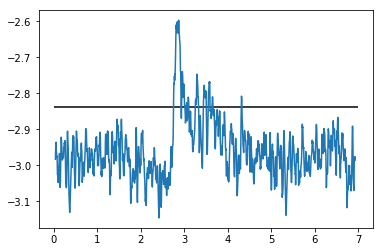

In [118]:
plt.plot(t, curve[55,:])
plt.hlines(thresh[55], 0, 7)
plt.show()
plt.close()

In [119]:
norm_curve = (curve - np.reshape(baseline_mu, (125,1))) / np.reshape(baseline_std, (125,1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


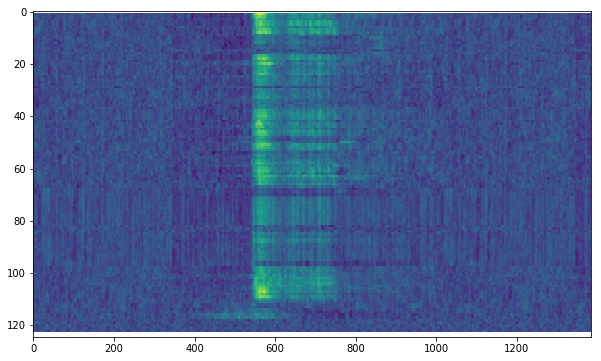

In [120]:
plt.figure(figsize=(10,6))
plt.imshow(norm_curve, aspect='auto')
# plt.plot(norm_curve[6,:])
plt.show()

In [22]:
np.size(p,-1)

1385

In [ ]:
bandpower = np.mean(np.mean(p,0)[0:60, :], 0)
plt.plot(bandpower)
plt.show()

In [ ]:
bandpower = np.mean(np.mean(p,0)[60:160, :], 0)
plt.plot(bandpower)
plt.show()

In [ ]:
for i in range(len(cue_onset)):
    plt.plot(np.mean(p[1,:,:], 0))
    plt.show()

In [ ]:
plt.figure(figsize=(25,np.size(cue_onset)))
plt.subplot(np.size(cue_onset)+1,1,1)
bandpower = np.mean(np.mean(p,0)[100:200, :], 0)
plt.plot(bandpower,'r')

for idx in range(np.size(cue_onset)):
    plt.subplot(np.size(cue_onset)+1,1,idx+2)
    plt.plot(np.mean(p[idx, :, :], 0))
    plt.xticks([])
#     plt.xlim([0, len(ch_bp_split[idx, :])])

plt.show()